In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import recall_score,accuracy_score,roc_auc_score,average_precision_score,roc_curve,auc,confusion_matrix
import shap


In [13]:
df_base=pd.read_excel('dataset_780.xlsx',sheet_name=0)

df_base = df_base.dropna(subset=['Diagnosis'])

mapping={
    'no':0,
    'yes':1,
    'male':1,
    'female':0,
    'normal':0,
    'diarrhea':1,
    'constipation':1,
    '+':1,
    '++':2,
    '+++':3,
    'local':1,
    'generalized':2,
    'appendicitis':1,
    'no appendicitis':0,
    'uncomplicated':0,
    'complicated':1,
}

for col in df_base.columns:
    df_base[col]=df_base[col].replace(mapping).fillna(0)

usg_col=['Appendix_Diameter']

# highly dependent features
dataset_1=['Nausea','Loss_of_Appetite','Peritonitis','WBC_Count','Neutrophil_Percentage','CRP','Ketones_in_Urine','Appendix_Diameter','Free_Fluids','Diagnosis']

# features without usg values
dataset_2=['Sex','BMI','Peritonitis','Ketones_in_Urine','Contralateral_Rebound_Tenderness','Nausea','Loss_of_Appetite','CRP','Lower_Right_Abd_Pain','Coughing_Pain','Migratory_Pain','Lower_Right_Abd_Pain'

           'WBC_Count','Neutrophil_Percentage','Body_Temperature','Ipsilateral_Rebound_Tenderness','Diagnosis']

/var/folders/gt/jkhq8fjj7rg_v80lhs4scmh80000gn/T/ipykernel_10146/2751017084.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_base[col]=df_base[col].replace(mapping).fillna(0)


In [14]:
# Model development for highly dependent features

df=df_base[dataset_1]





x = df.iloc[:, 0:-1]  
y = df.iloc[:, -1]



x_temp,x_test, y_temp,y_test = train_test_split(x,y,test_size=0.2,random_state=88)
x_train,x_val,y_train,y_val = train_test_split(x_temp,y_temp,test_size=0.25,random_state=88)









In [15]:
dharma=RandomForestClassifier(
    n_estimators=555,
    min_samples_split=12,
    min_samples_leaf=1,
    max_depth=35,
    random_state=17,
    class_weight="balanced"
)

scores = cross_val_score(dharma, x_train, y_train, cv=10, scoring='accuracy', n_jobs=2)
print("Mean cross_val accuracy Score:", scores.mean())
print("Standard Deviation of cross_val accuracy Scores:", scores.std())

scores_auc = cross_val_score(dharma, x_train, y_train, cv=10, scoring='roc_auc', n_jobs=2)
print("Mean cross_val auc-roc score:", scores_auc.mean())
print("Standard Deviation of auc-roc Scores:", scores_auc.std())

scores_auc = cross_val_score(dharma, x_train, y_train, cv=10, scoring='recall', n_jobs=2)
print("Mean cross_val recall score:", scores_auc.mean())
print("Standard Deviation of recall Scores:", scores_auc.std())



Mean cross_val accuracy Score: 0.8954671600370027
Standard Deviation of cross_val accuracy Scores: 0.03608422816348121
Mean cross_val auc-roc score: 0.960609857978279
Standard Deviation of auc-roc Scores: 0.019933722761169812
Mean cross_val recall score: 0.9121693121693122
Standard Deviation of recall Scores: 0.04094209159392754


In [16]:
dharma.fit(x_train,y_train)

y_pred_prob=dharma.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

distances = np.sqrt((1 - tpr)**2 + fpr**2)
optimal_idx_eu = np.argmin(distances)
optimal_threshold_eu = thresholds[optimal_idx_eu]

print(f"Optimal Threshold Youden: {optimal_threshold} and Optimal Euclidean Distance :{optimal_threshold_eu}")

threshold_y = optimal_threshold
threshold_eu = optimal_threshold_eu


y_val_prob=dharma.predict_proba(x_val)[:,1]
y_thres=(y_val_prob >= threshold_y).astype(int)
auc_score = roc_auc_score(y_val, y_val_prob)
print("Val AUC:", auc_score)
val_conf_matrix = confusion_matrix(y_val, y_thres)
TNv, FPv, FNv, TPv = val_conf_matrix.ravel()
val_sensitivity = TPv / (TPv + FNv)
val_specificity = TNv / (TNv + FPv)
val_ppv = TPv/(TPv+FPv)
val_npv = TNv/(TNv+FNv)

print("For Youden Index")

print(f"Sensitivity: {val_sensitivity:.3f} ({val_sensitivity * 100:.2f}%)")
print(f"Specificity: {val_specificity:.3f} ({val_specificity * 100:.2f}%)")

print (f"Positive predictive value : {val_ppv:.3f}({val_ppv*100:.2f}%)")
print (f"Negative predictive value : {val_npv:.3f}({val_npv*100:.2f}%)")

print("Val Confusion Matrix:\n", val_conf_matrix)
val_acu=accuracy_score(y_val,y_thres)
print("Val accuracy score:",val_acu)

y_val_prob=dharma.predict_proba(x_val)[:,1]
y_thres=(y_val_prob >= threshold_eu).astype(int)
auc_score = roc_auc_score(y_val, y_val_prob)
print("Val AUC:", auc_score)
val_conf_matrix = confusion_matrix(y_val, y_thres)
TNv, FPv, FNv, TPv = val_conf_matrix.ravel()
val_sensitivity = TPv / (TPv + FNv)
val_specificity = TNv / (TNv + FPv)
val_ppv = TPv/(TPv+FPv)
val_npv = TNv/(TNv+FNv)

print("For Eucledean distance")

print(f"Sensitivity: {val_sensitivity:.3f} ({val_sensitivity * 100:.2f}%)")
print(f"Specificity: {val_specificity:.3f} ({val_specificity * 100:.2f}%)")

print (f"Positive predictive value : {val_ppv:.3f}({val_ppv*100:.2f}%)")
print (f"Negative predictive value : {val_npv:.3f}({val_npv*100:.2f}%)")

print("Val Confusion Matrix:\n", val_conf_matrix)
val_acu=accuracy_score(y_val,y_thres)
print("Val accuracy score:",val_acu)


Optimal Threshold Youden: 0.6579713026236363 and Optimal Euclidean Distance :0.591545372068296
Val AUC: 0.9680134680134681
For Youden Index
Sensitivity: 0.889 (88.89%)
Specificity: 0.955 (95.45%)
Positive predictive value : 0.964(96.39%)
Negative predictive value : 0.863(86.30%)
Val Confusion Matrix:
 [[63  3]
 [10 80]]
Val accuracy score: 0.9166666666666666
Val AUC: 0.9680134680134681
For Eucledean distance
Sensitivity: 0.933 (93.33%)
Specificity: 0.909 (90.91%)
Positive predictive value : 0.933(93.33%)
Negative predictive value : 0.909(90.91%)
Val Confusion Matrix:
 [[60  6]
 [ 6 84]]
Val accuracy score: 0.9230769230769231


In [17]:
# # # Testing
threshold=threshold_eu

dharma.fit(x_train,y_train)#Diagnosis is the target variable

# y_test=np.ravel(y_test)
dharma_prob=dharma.predict_proba(x_test)[:,1]
dharma_predict=(dharma_prob>=threshold).astype(int)
dharma_predict=dharma.predict(x_test)

auc_score = roc_auc_score(y_test, dharma_prob)
print("AUC:", auc_score)
conf_matrix = confusion_matrix(y_test, dharma_predict)
TNv, FPv, FNv, TPv = conf_matrix.ravel()
sensitivity = TPv / (TPv + FNv)
specificity = TNv / (TNv + FPv)
ppv = TPv/(TPv+FPv)
npv = TNv/(TNv+FNv)


print(f"Sensitivity: {sensitivity:.3f} ({sensitivity * 100:.2f}%)")
print(f"Specificity: {specificity:.3f} ({specificity * 100:.2f}%)")

print (f"Positive predictive value : {ppv:.3f}({ppv*100:.2f}%)")
print (f"Negative predictive value : {npv:.3f}({npv*100:.2f}%)")

print("Confusion Matrix:\n", conf_matrix)
acu=accuracy_score(y_test,dharma_predict)
print("Accuracy score:",acu)


AUC: 0.9769642857142857
Sensitivity: 0.950 (95.00%)
Specificity: 0.875 (87.50%)
Positive predictive value : 0.931(93.14%)
Negative predictive value : 0.907(90.74%)
Confusion Matrix:
 [[49  7]
 [ 5 95]]
Accuracy score: 0.9230769230769231


In [18]:


df_test= pd.concat([x_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_test= df_test[df_test['Appendix_Diameter'] == 0]
print(df_test.shape)







(47, 9)


In [19]:

df_old=pd.read_excel('dataset_unique.xlsx')





df_old=df_old[dataset_1]


x_old=df_old.iloc[:, 0:-1] 
y_old=df_old.iloc[:, -1]




threshold=threshold_eu
old_prob=dharma.predict_proba(x_old)[:,1]
old_pred=(old_prob>=threshold).astype(int)

auc_score=roc_auc_score(y_old,old_prob)
print("AUC:", auc_score)

conf_matrix = confusion_matrix(y_old,old_pred)
TNv, FPv, FNv, TPv = conf_matrix.ravel()
sensitivity = TPv / (TPv + FNv)
specificity = TNv / (TNv + FPv)
ppv = TPv/(TPv+FPv)
npv = TNv/(TNv+FNv)

print(f"Sensitivity: {sensitivity:.3f} ({sensitivity * 100:.2f}%)")
print(f"Specificity: {specificity:.3f} ({specificity * 100:.2f}%)")

print (f"Positive predictive value : {ppv:.3f}({ppv*100:.2f}%)")
print (f"Negative predictive value : {npv:.3f}({npv*100:.2f}%)")

print("Confusion Matrix:\n", conf_matrix)
acu=accuracy_score(y_old,old_pred)
print("Accuracy score:",acu)







AUC: 0.9735119047619047
Sensitivity: 0.907 (90.71%)
Specificity: 0.979 (97.92%)
Positive predictive value : 0.984(98.45%)
Negative predictive value : 0.879(87.85%)
Confusion Matrix:
 [[ 94   2]
 [ 13 127]]
Accuracy score: 0.9364406779661016


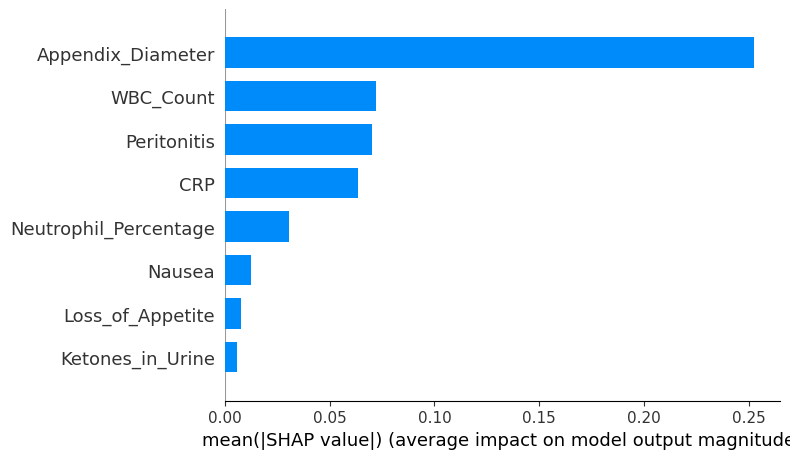

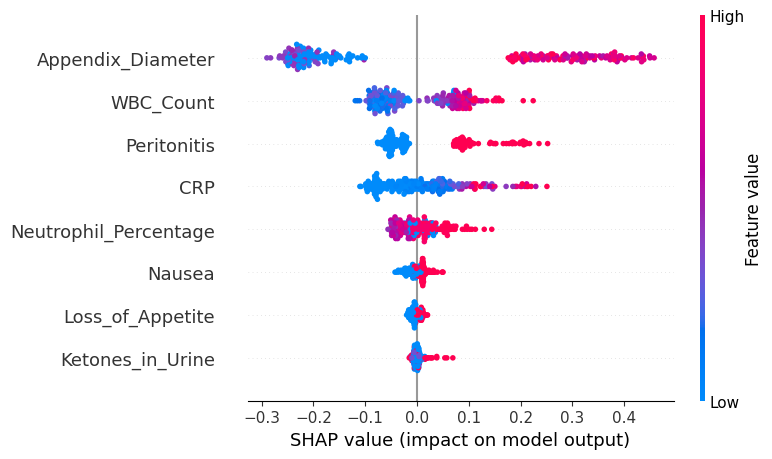

base value: 0.49988299839467804
                 Feature  Importance
7      Appendix_Diameter    0.484170
3              WBC_Count    0.164452
5                    CRP    0.133628
4  Neutrophil_Percentage    0.088590
2            Peritonitis    0.086994
0                 Nausea    0.015742
6       Ketones_in_Urine    0.015668
1       Loss_of_Appetite    0.010756


In [20]:
# Explainability of the model

# SHAP explanation
explainer=shap.TreeExplainer(dharma)
shap_values=explainer.shap_values(x_old)
shap.summary_plot(shap_values[:,:,1],x_old,plot_type="bar",max_display=10)
shap.summary_plot(shap_values[:,:,1],x_old,plot_type="dot",max_display=10)
base_values=explainer.expected_value[1]
print("base value:",base_values)

# Feature importance
importances = dharma.feature_importances_
feature_importances_df=pd.DataFrame({
    'Feature': x_old.columns,
    'Importance': importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)




(127, 9)
AUC: 0.94795978710822
Sensitivity: 0.921 (92.11%)
Specificity: 0.798 (79.78%)
Positive predictive value : 0.660(66.04%)
Negative predictive value : 0.959(95.95%)
Confusion Matrix:
 [[71 18]
 [ 3 35]]
Accuracy score: 0.8346456692913385


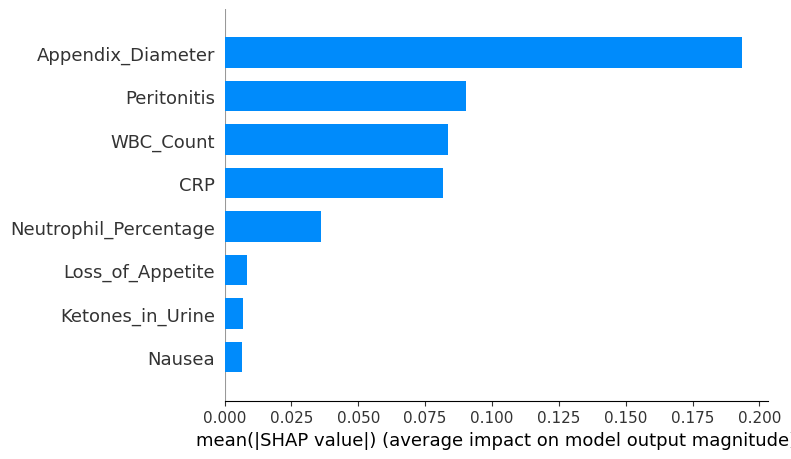

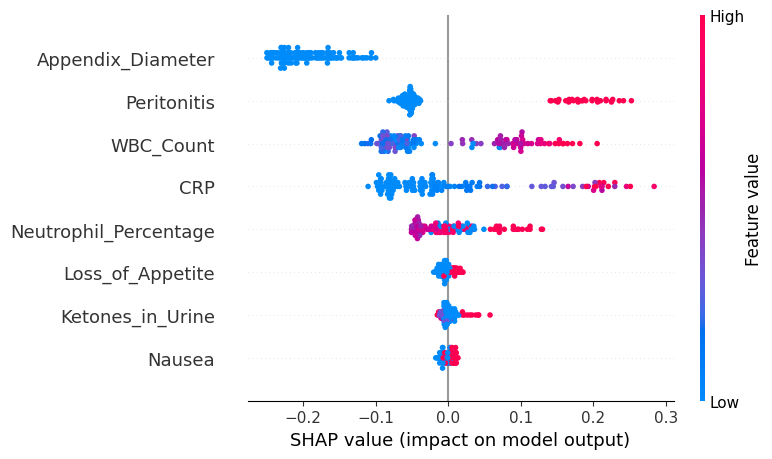

In [21]:



df_wousg1=df_old.copy()
df_wousg1 = df_wousg1[df_wousg1['Appendix_Diameter'] == 0]

df_wousg=pd.concat([df_wousg1.reset_index(drop=True), df_test.reset_index(drop=True)],axis=0)

print (df_wousg.shape)

df_wousg=df_wousg[dataset_1]
df_old=df_old[dataset_1]
df_old=df_wousg

x_old=df_old.iloc[:, 0:-1] 
y_old=df_old.iloc[:, -1]




threshold=0.30
old_prob=dharma.predict_proba(x_old)[:,1]
old_pred=(old_prob>=threshold).astype(int)

auc_score=roc_auc_score(y_old,old_prob)
print("AUC:", auc_score)

conf_matrix = confusion_matrix(y_old,old_pred)
TNv, FPv, FNv, TPv = conf_matrix.ravel()
sensitivity = TPv / (TPv + FNv)
specificity = TNv / (TNv + FPv)
ppv = TPv/(TPv+FPv)
npv = TNv/(TNv+FNv)

print(f"Sensitivity: {sensitivity:.3f} ({sensitivity * 100:.2f}%)")
print(f"Specificity: {specificity:.3f} ({specificity * 100:.2f}%)")

print (f"Positive predictive value : {ppv:.3f}({ppv*100:.2f}%)")
print (f"Negative predictive value : {npv:.3f}({npv*100:.2f}%)")

print("Confusion Matrix:\n", conf_matrix)
acu=accuracy_score(y_old,old_pred)
print("Accuracy score:",acu)

# Explainability of the model
shap_values=explainer.shap_values(x_old)
shap.summary_plot(shap_values[:,:,1],x_old,plot_type="bar",max_display=10)
shap.summary_plot(shap_values[:,:,1],x_old,plot_type="dot",max_display=10)






In [22]:
# data = {
#     'Appendix_Diameter': [0,0],
#     'Nausea': [0,1],
#     'Loss_of_Appetite': [1,0],
#     'Peritonitis':[1,1],
#     'WBC_Count':[11,8.2],
#     'Neutrophil_Percentage':[79,60],
#     'CRP':[0,0],
#     'Ketones_in_Urine':[1,0],
#     'Free_Fluids':[1,0]
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# abc=dharma.predict_proba(df)
# print(abc)